## Names
Joseph Moyalan, Kent Hansen, Sahithi Golkonda, Pranay Kalagara

# Project : NBA Shotlogs

The problem we are trying to solve is to figure out when a player shoots whether or not he will make it. This matters because the results can be helpful for NBA teams to improve player performances on and off the ball. We can also usew this to draft players and to analyze how opponent NBA teams play. We want to predict this to help NBA teams improve their chances of winning and making shots. For this task we will be using the NBA shotlogs dataset, which contains many factors which can relate to whether or not a given shot can go in such as player, distance, shot clock, and closest_defender. This dataset has `128069` instances and `20` attributes (some categorical, some continuous).

In [49]:
import warnings
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import math

In [3]:
%matplotlib inline

In [12]:
raw_data = pd.read_csv("shot_logs.csv")
raw_data

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,5,3,1:52,18.3,5,...,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,6,4,11:28,19.8,4,...,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,7,4,11:10,23.0,2,...,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,"OCT 29, 2014 - BKN @ BOS",A,L,-16,8,4,2:37,9.1,4,...,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


### A. Data prep

In [52]:
#Drop fields
col_names_drop = ["GAME_ID", "MATCHUP", "FINAL_MARGIN", "DRIBBLES", "CLOSEST_DEFENDER_PLAYER_ID", "SHOT_RESULT", "PTS", "player_id"]
data = raw_data.drop(labels = col_names_drop, axis = 1)
data = data[data["TOUCH_TIME"] >= 0]

#Get rid of NaN
cnt=0
for row in data:
    if math.isnan(data.loc[cnt, "SHOT_CLOCK"]):
        data.loc[cnt, "SHOT_CLOCK"] = float(data["GAME_CLOCK"][cnt].split(":")[1])
    cnt+=1
    
#Rename FGM to Label
data = data.rename(columns = {"FGM" : "Label"})
data = data.rename(columns = {"W" : "WIN/LOSS"})
data = data.rename(columns = {"LOCATION" : "HOME/AWAY"})

#Drop duplicates
data.drop_duplicates(inplace = True)

#Change values for WIN/LOSS and HOME/AWAY to Boolean
data["WIN/LOSS"].replace({"W" : 1, "L" : 0}, inplace = True)
data["HOME/AWAY"].replace({"H" : 1, "A" : 0}, inplace = True)

#Get label and feture
labels = data.iloc[:, 11]
features = data.drop(labels = ["Label"], axis = 1)
features.head()

,HOME/AWAY,WIN/LOSS,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER,CLOSE_DEF_DIST,player_name
0,0,1,1,1,1:09,10.8,1.9,7.7,2,"Anderson, Alan",1.3,brian roberts
1,0,1,2,1,0:14,3.4,0.8,28.2,3,"Bogdanovic, Bojan",6.1,brian roberts
2,0,1,3,1,0:00,0.0,2.7,10.1,2,"Bogdanovic, Bojan",0.9,brian roberts
3,0,1,4,2,11:47,10.3,1.9,17.2,2,"Brown, Markel",3.4,brian roberts
4,0,1,5,2,10:34,10.9,2.7,3.7,2,"Young, Thaddeus",1.1,brian roberts


### B. Data Exploration

<AxesSubplot:title={'center':'Shot Distance Outliers'}>

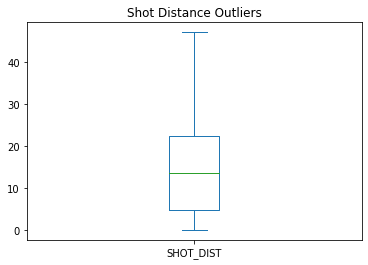

In [31]:
#See if outliers present for Shot distances
shot_dist = features['SHOT_DIST']
shot_dist.plot(kind='box', title = 'Shot Distance Outliers')

<AxesSubplot:xlabel='PERIOD'>

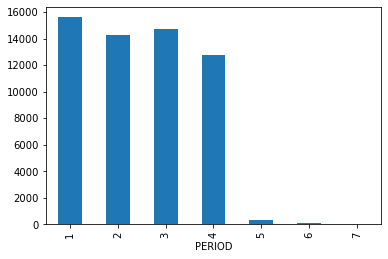

In [54]:
#Shots made based on Period
data.groupby(['PERIOD'])['Label'].sum().plot(kind="bar", capsize=10)

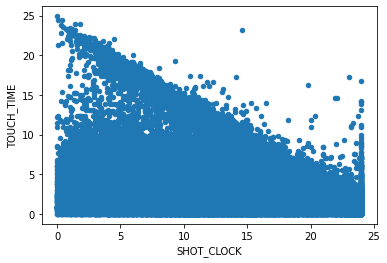

In [53]:
#Correlation between Shot clock and touch time
x2 = data.plot.scatter(x='SHOT_CLOCK',y='TOUCH_TIME')

<AxesSubplot:xlabel='PTS_TYPE'>

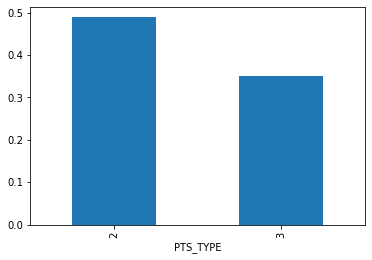

In [64]:
#Shots made based on Pts
data.groupby(['PTS_TYPE'])['Label'].mean().plot(kind="bar")

### C. Feature Engineering